# Object classification with scikit-learn

Based on size and shape measurements, e.g. derived using [scikit-image `regionprops`]() and some sparse ground truth annotation, we can classify objects. A common algorithm for this are [Random Forest Classifiers](https://en.wikipedia.org/wiki/Random_forest). A commonly used implementation is available as [scikit-learn Random Forest Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html).

See also
* [Machine learning for pixel and object classification (video lecture)](https://www.youtube.com/watch?v=dstjhCPBDOY&list=PL5ESQNfM5lc7SAMstEu082ivW4BDMvd0U&index=19)

In [8]:
from sklearn.ensemble import RandomForestClassifier

from skimage.io import imread
from skimage.filters import threshold_otsu
from skimage.measure import label, regionprops
from skimage.segmentation import clear_border
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Our starting point are an image, a label image and some ground truth annotation. The annotation is also a label image where the user was just drawing lines with different intensity (class) through small objects, large objects and elongated objects.

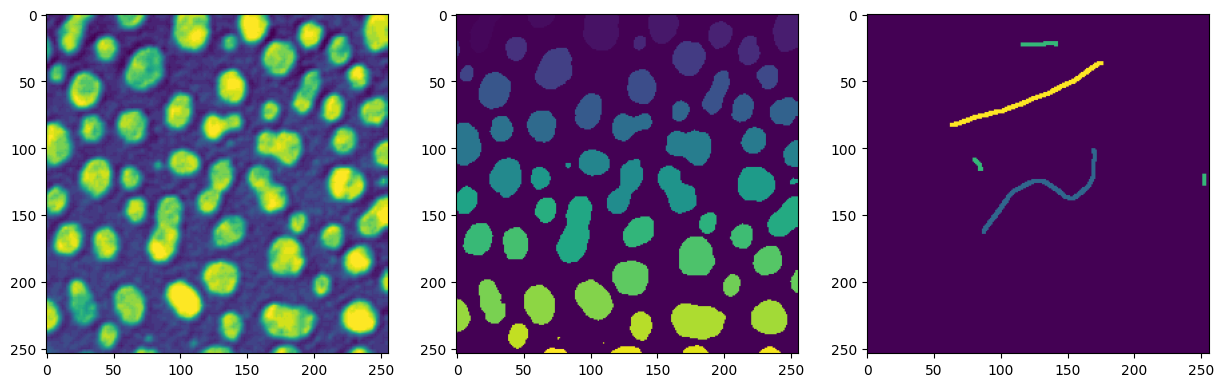

In [9]:
# load and label data
image = imread('data/blobs.tif')
labels = label(image > threshold_otsu(image))
annotation = imread('data/label_annotation.tif')

# visualize
fig, ax = plt.subplots(1,3, figsize=(15,15))
ax[0].imshow(image)
ax[1].imshow(labels)
ax[2].imshow(annotation)
ax[2].imshow(annotation, alpha=0.7)

## Feature extraction
The first step to classify objects according to their properties is [feature extraction](feature_extraction).

In [10]:
stats = regionprops(labels, intensity_image=image)

# read out specific measurements
label_ids =          np.asarray([s.label for s in stats])
areas =              np.asarray([s.area for s in stats])
minor_axis_lengths = np.asarray([s.minor_axis_length for s in stats])
major_axis_lengths = np.asarray([s.major_axis_length for s in stats])

# compute additional parameters
aspect_ratios = major_axis_lengths / minor_axis_lengths

C:\Users\marqu\AppData\Local\Temp\ipykernel_6696\1513904267.py:10: RuntimeWarning: invalid value encountered in divide
  aspect_ratios = major_axis_lengths / minor_axis_lengths


We also read out the maximum intensity of every labeled object from the ground truth annotation. These values will serve to train the classifier.

In [11]:
annotation_stats = regionprops(labels, intensity_image=annotation)

annotated_class = np.asarray([s.max_intensity for s in annotation_stats])

## Data wrangling

To look at the data before it is fed to the training, we visualize it as [pandas DataFrame](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html). Note: The rows with `annotated_class=0` correspond to labels that have not been annotated.

In [12]:
data = {
    'label': label_ids,
    'area': areas,
    'minor_axis': minor_axis_lengths,
    'major_axis': major_axis_lengths,
    'aspect_ratio': aspect_ratios,
    'annotated_class': annotated_class
}

table = pd.DataFrame(data)

# show only first 5 rows
table.iloc[:5]

,label,area,minor_axis,major_axis,aspect_ratio,annotated_class
0,1,433.0,16.819060,34.957399,2.078439,0.0
1,2,185.0,11.803854,21.061417,1.784283,0.0
2,3,658.0,28.278264,30.212552,1.068402,2.0
3,4,434.0,23.064079,24.535398,1.063793,0.0
4,5,477.0,19.833058,31.162612,1.571246,0.0


From that table, we extract now a table that only contains the annotated rows/labels.

In [13]:
annotated_table = table[table['annotated_class'] > 0]
annotated_table

,label,area,minor_axis,major_axis,aspect_ratio,annotated_class
2,3,658.0,28.278264,30.212552,1.068402,2.0
6,7,81.0,9.239435,11.153514,1.207164,2.0
10,11,501.0,24.403675,26.232105,1.074924,3.0
14,15,448.0,21.751312,26.272749,1.207870,3.0
17,18,425.0,19.335056,28.075209,1.452037,3.0
21,22,412.0,21.819832,24.135300,1.106118,3.0
26,27,676.0,24.623036,36.525858,1.483402,1.0
30,31,610.0,17.433716,48.005150,2.753581,1.0
31,32,14.0,4.120630,4.208834,1.021406,2.0
32,33,641.0,21.042345,40.781012,1.938045,1.0


As we do not want to use all columns for training, we now select the right columns. It is recommended to write a short convenience function `select_data` for this, because we will reuse it later for prediction.

In [14]:
def select_data(table):
    return np.asarray([
        table['area'],
        table['aspect_ratio']
    ])

training_data = select_data(annotated_table).T
training_data

array([[658.        ,   1.06840194],
       [ 81.        ,   1.20716407],
       [501.        ,   1.07492436],
       [448.        ,   1.20786966],
       [425.        ,   1.45203663],
       [412.        ,   1.1061176 ],
       [676.        ,   1.48340188],
       [610.        ,   2.75358106],
       [ 14.        ,   1.02140552],
       [641.        ,   1.93804502],
       [ 22.        ,   1.4912077 ],
       [902.        ,   2.51986728]])

We also extract the annotation from that table and call it `ground_truth`.

In [15]:
ground_truth = annotated_table['annotated_class'].tolist()
ground_truth

[2.0, 2.0, 3.0, 3.0, 3.0, 3.0, 1.0, 1.0, 2.0, 1.0, 2.0, 1.0]

## Classifier Training
Next, we can train the [Random Forest Classifer](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html). It needs training data and ground truth in the format presented above.

In [16]:
classifier = RandomForestClassifier(max_depth=2, n_estimators=10, random_state=0)
classifier.fit(training_data, ground_truth)

RandomForestClassifier(max_depth=2, n_estimators=10, random_state=0)

## Prediction
To apply a classifier to the whole dataset, or any other dataset, we need to bring the data into the same format as used for training. We can reuse the function `select_data` for that. Furthermore, we need to drop rows from our table where not-a-number ([NaN](https://en.wikipedia.org/wiki/NaN)) values appeared ([read more](tabular_data_wrangling.handling_nan_values)).

In [17]:
table_without_nans = table.dropna(how="any")

all_data = select_data(table_without_nans).T
all_data

array([[433.        ,   2.0784395 ],
       [185.        ,   1.78428301],
       [658.        ,   1.06840194],
       [434.        ,   1.06379267],
       [477.        ,   1.57124594],
       [285.        ,   1.15397362],
       [ 81.        ,   1.20716407],
       [278.        ,   1.39040997],
       [231.        ,   1.14134293],
       [ 30.        ,   4.64290752],
       [501.        ,   1.07492436],
       [660.        ,   1.33770096],
       [ 99.        ,   1.27265076],
       [228.        ,   1.1427708 ],
       [448.        ,   1.20786966],
       [401.        ,   2.50541908],
       [520.        ,   1.18241662],
       [425.        ,   1.45203663],
       [271.        ,   1.34918562],
       [350.        ,   1.16890653],
       [159.        ,   1.22661614],
       [412.        ,   1.1061176 ],
       [426.        ,   1.81249164],
       [260.        ,   1.15413724],
       [506.        ,   1.6790716 ],
       [289.        ,   1.13174859],
       [676.        ,   1.48340188],
 

We can then hand over `all_data` to the classifier for prediction.

In [18]:
table_without_nans['predicted_class'] = classifier.predict(all_data)
print(table_without_nans['predicted_class'].tolist())

[1.0, 1.0, 2.0, 3.0, 3.0, 3.0, 2.0, 3.0, 2.0, 1.0, 3.0, 3.0, 2.0, 2.0, 3.0, 1.0, 3.0, 3.0, 3.0, 3.0, 2.0, 3.0, 1.0, 3.0, 3.0, 3.0, 3.0, 1.0, 3.0, 3.0, 1.0, 2.0, 1.0, 2.0, 2.0, 3.0, 3.0, 1.0, 1.0, 2.0, 2.0, 3.0, 3.0, 2.0, 3.0, 2.0, 3.0, 2.0, 1.0, 3.0, 1.0, 3.0, 3.0, 1.0, 3.0, 3.0, 3.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0]


C:\Users\marqu\AppData\Local\Temp\ipykernel_6696\549567337.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table_without_nans['predicted_class'] = classifier.predict(all_data)


We can then merge the table containing the `predicted_class` column with the original table. In the resulting `table_with_prediction`, we still need to decide how to handle `NaN` values. It is not possible to classify those because measurements are missing. Thus, we replace the class of those with 0 using [`fillna`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.fillna.html).

In [19]:
# merge prediction with original table
table_with_prediction = table.merge(table_without_nans, how='outer', on='label')
# replace not predicted (NaN) with 0
table_with_prediction['predicted_class'] = table_with_prediction['predicted_class'].fillna(0)

table_with_prediction

,label,area_x,minor_axis_x,major_axis_x,aspect_ratio_x,annotated_class_x,area_y,minor_axis_y,major_axis_y,aspect_ratio_y,annotated_class_y,predicted_class
0,1,433.0,16.819060,34.957399,2.078439,0.0,433.0,16.819060,34.957399,2.078439,0.0,1.0
1,2,185.0,11.803854,21.061417,1.784283,0.0,185.0,11.803854,21.061417,1.784283,0.0,1.0
2,3,658.0,28.278264,30.212552,1.068402,2.0,658.0,28.278264,30.212552,1.068402,2.0,2.0
3,4,434.0,23.064079,24.535398,1.063793,0.0,434.0,23.064079,24.535398,1.063793,0.0,3.0
4,5,477.0,19.833058,31.162612,1.571246,0.0,477.0,19.833058,31.162612,1.571246,0.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...
59,60,1.0,0.000000,0.000000,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0
60,61,81.0,5.920690,18.558405,3.134500,0.0,81.0,5.920690,18.558405,3.134500,0.0,1.0
61,62,90.0,5.369081,22.458271,4.182889,0.0,90.0,5.369081,22.458271,4.182889,0.0,1.0
62,63,53.0,5.065719,14.811463,2.923862,0.0,53.0,5.065719,14.811463,2.923862,0.0,1.0


From that table, we can extract the column containing the prediction and use [`replace_intensities`](https://clij.github.io/clij2-docs/reference_replaceIntensities) to generate a `class_image`. The background and objects with NaNs in measurements will have value 0 in that image.

In [20]:
# we add a 0 for the class of background at the beginning
predicted_class = [0] + table_with_prediction['predicted_class'].tolist() 

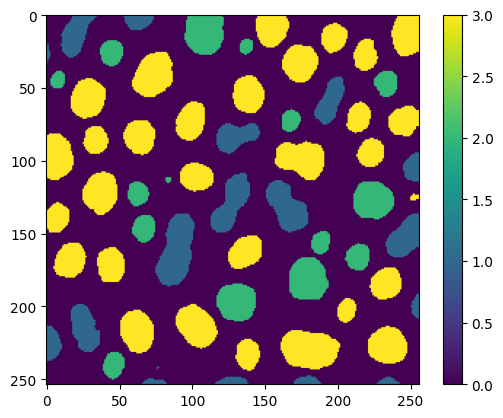

In [24]:
#class_image = replace_intensities(labels, predicted_class)
class_image = labels.copy()
for s in stats:
    class_image[class_image == s.label] = predicted_class[s.label]

plt.imshow(class_image)
plt.colorbar()